In [541]:
% matplotlib inline

import json, re
import fiona
from shapely.geometry import MultiPolygon, shape

import pandas as pd
import geopandas as gp
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

from mpl_toolkits.basemap import Basemap

from descartes import PolygonPatch

from datetime import datetime
from dateutil.parser import parse

from pysal.esda.mapclassify import Natural_Breaks as nb
from itertools import chain

In [241]:
matplotlib.style.use('ggplot')

#### Create Dublin Electoral Division basemap from CSO boundary files (already converted to geojson)

In [29]:
with open("../data/raw/dublin_ed.geojson", "r") as f:
    dub = json.load(f)

In [22]:
# Creating new geojson for geometries and basic id info
# Including Ward names to incorporate 1961 data
dub2 = {'type':dub['type'], 'crs': dub['crs'], 'features': []}
for feat in dub['features']:
    prop = feat
    prop['properties'] = {"ed": feat['properties']['EDNAME'],
           "geogid": feat['properties']['GEOGID'],
           "osied": feat['properties']['OSIED'],
           "ward": re.sub("\s[A-Z]$", "", feat['properties']['EDNAME'])}
    dub2['features'].append(prop)

with open("../data/processed/dublin_ed_base.geojson", "w") as f:
    json.dump(dub2, f, indent=2, sort_keys=True)

In [250]:
#Create Geopandas data frame from dublin data
dub_gp = gp.GeoDataFrame.from_file("../data/processed/dublin_ed_base.geojson")
dub_gp.set_index("geogid")
dub_gp.geometry.total_bounds

(-6.3563323952617958,
 53.307849989167117,
 -6.113090271214344,
 53.387929189912107)

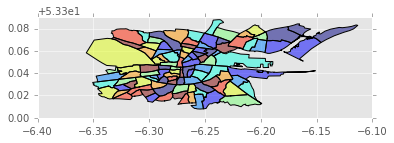

In [246]:
dub_gp.plot(legend=True)

In [167]:
#Import census tenure data into dataframe
with open("../data/interim/ten_71_81_91_02_11.json", "r") as f:
    tenure = json.load(f)
ten_df = pd.DataFrame.from_dict(data)

In [166]:
ten_df[ten_df['year']==1971].describe()

,local_authority_hhlds,local_authority_p_in_hhlds,local_authority_units,owner_mortg_hhlds,owner_mortg_p_in_hhlds,owner_mortg_units,owner_no_mortg_hhlds,owner_no_mortg_p_in_hhlds,owner_no_mortg_units,owner_occ_hhlds,...,rent_furn_units,rent_unfurn_hhlds,rent_unfurn_p_in_hhlds,rent_unfurn_units,total_hhlds,total_p_in_hhlds,total_units,vol_body_hhlds,vol_body_units,year
count,0.0,0.0,142.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,142.000000,0.0,0.0,142.000000,0.0,0.0,142.000000,0.0,0.0,142.0
mean,NaN,NaN,882.091549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,136.633803,NaN,NaN,338.274648,NaN,NaN,2665.521127,NaN,NaN,1971.0
std,NaN,NaN,4244.631354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,671.759365,NaN,NaN,1643.371488,NaN,NaN,12869.585922,NaN,NaN,0.0
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,0.000000,NaN,NaN,264.000000,NaN,NaN,1971.0
25%,NaN,NaN,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.000000,NaN,NaN,17.000000,NaN,NaN,700.250000,NaN,NaN,1971.0
50%,NaN,NaN,187.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.000000,NaN,NaN,86.500000,NaN,NaN,899.500000,NaN,NaN,1971.0
75%,NaN,NaN,550.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.000000,NaN,NaN,163.750000,NaN,NaN,1125.000000,NaN,NaN,1971.0
max,NaN,NaN,41819.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6496.000000,NaN,NaN,16052.000000,NaN,NaN,127042.000000,NaN,NaN,1971.0


In [233]:
for t in tenure:
    t['year'] = str(t['year'])

dub_df = pd.DataFrame.from_dict(sorted(({k:t[k] for k in t if k in ['area', 'geogid', "year"] or k.endswith("units")}
                                for t in tenure if t['geogid'] == "C02"), key=lambda x: x['year']))

dub_df.set_index("year")
dub_df.loc[dub_df['owner_occ_units'].isnull(), 'owner_occ_units'] = dub_df['owner_mortg_units']+dub_df['owner_no_mortg_units']
dub_df.loc[dub_df['private_rent_units'].isnull(), 'private_rent_units'] = dub_df['rent_furn_units']+dub_df['rent_unfurn_units']


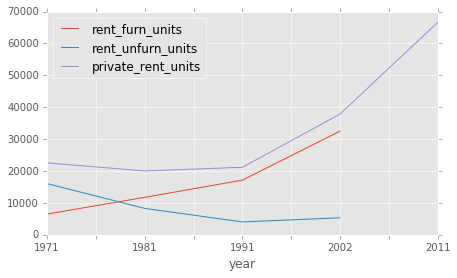

In [266]:
ax = plt.figure(figsize=(7,4), dpi=300).add_subplot(111)
dub_df.plot(ax=ax, x="year", y=['rent_furn_units', 'rent_unfurn_units', "private_rent_units"])

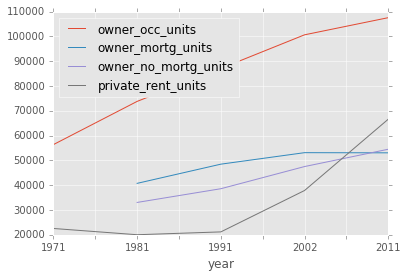

In [546]:
#bx = plt.figure(figsize=(7,4), dpi=300).add_subplot(111)
dub_df.plot(x="year", y=['owner_occ_units', 'owner_mortg_units', "owner_no_mortg_units", "private_rent_units"])

In [528]:
dub71 = pd.DataFrame.from_dict({k:t[k] for k in t if k in ['area', 'geogid', "year"] or k.endswith("units")}
                                for t in tenure if t['geogid'] and t['geogid'].startswith("E") and t['year'] == "2002")
dub71.set_index("geogid")
dub71.describe()

,local_authority_units,not_stated_units,owner_mortg_units,owner_no_mortg_units,owner_occ_units,purch_sch_units,rent_free_units,rent_furn_units,rent_unfurn_units,total_units
count,162.000000,162.000000,162.000000,162.00000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,120.901235,58.907407,327.901235,293.32716,621.228395,66.771605,13.660494,200.790123,32.932099,1115.191358
std,148.307939,41.052126,206.462341,185.86420,354.878464,72.521770,11.544224,227.419426,45.697374,407.014391
min,2.000000,4.000000,20.000000,2.00000,22.000000,0.000000,0.000000,1.000000,1.000000,223.000000
25%,23.000000,31.250000,203.250000,154.50000,376.500000,9.000000,5.000000,27.000000,8.000000,852.000000
50%,72.500000,45.500000,304.500000,271.00000,601.000000,39.000000,11.000000,117.500000,17.500000,1057.000000
75%,158.750000,80.000000,415.750000,420.50000,823.000000,102.500000,18.750000,289.750000,39.000000,1382.000000
max,913.000000,307.000000,1598.000000,954.00000,1948.000000,301.000000,69.000000,1066.000000,407.000000,2372.000000


In [542]:
bds = dub_gp.total_bounds
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01

In [543]:
?Basemap.readshapefile

In [545]:
m = Basemap(
    projection='tmerc',
    lon_0=-2.,
    lat_0=49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    '../data/external/census2011DED/Census2011_Electoral_Divisions_generalised20m',
    'Dublin City',
    color='none',
    zorder=2)

ImportError: No module named 'shapefile'

In [529]:
# Calculate Jenks natural breaks for density
breaks = nb(
    dub71[dub71['rent_furn_units'].notnull()].rent_unfurn_units.values,
    initial=300,
    k=5)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=dub71[dub71['rent_furn_units'].notnull()].index)
dub71 = dub71.join(jb)
dub71.jenks_bins.fillna(-1, inplace=True)

jenks_labels = ["<= %0.f units (%s EDs)" % (b, c) for b, c in zip(
    breaks.bins, breaks.counts)]
#jenks_labels.insert(0, 'No plaques (%s wards)' % len(df_map[df_map['density_km'].isnull()]))
jenks_labels

['<= 19 units (86 EDs)',
 '<= 49 units (44 EDs)',
 '<= 107 units (27 EDs)',
 '<= 228 units (4 EDs)',
 '<= 407 units (1 EDs)']

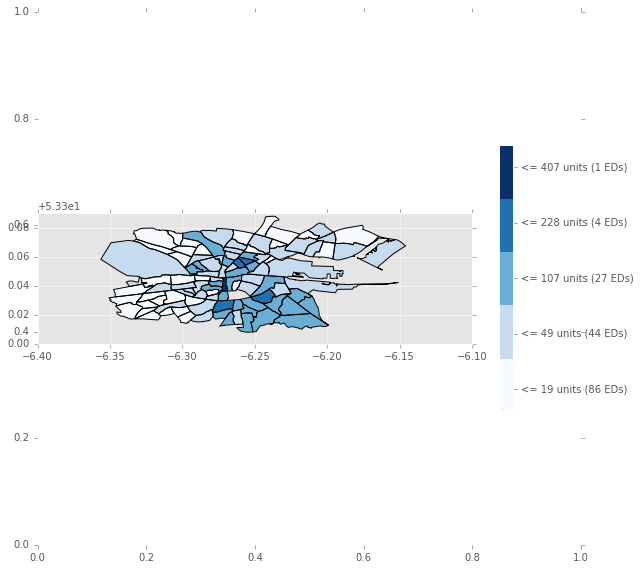

In [534]:
#fig = plt.figure(figsize=(20,15), dpi=300)#.add_subplot(111)
plt.clf()
fig = plt.figure()

ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
# draw wards with grey outlines
patches = []

d71 = pd.merge(dub_gp,dub71)
d71['patches'] = d71.geometry.map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(d71['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(d71['jenks_bins'].values)))
ax.add_collection(pc)

d71.plot(column="jenks_bins", colormap="Blues", 
                              categorical=True, 
                               alpha=1.0, 
                               
                               )
# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=10)

# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(12,8)
#plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
plt.show()

In [430]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [327]:
[(t['geogid'], t['area'], t['year']) for t in tenure if t['geogid'] == "E02146"]

[('E02146', 'St Kevins', '1981'),
 ('E02146', 'St Kevins', '1991'),
 ('E02146', 'St Kevins', '2002'),
 ('E02146', 'St Kevins', '1971'),
 ('E02146', "St. Kevin's", '2011')]

In [412]:
dub_gp['geometry'].iloc[6:8].values

array([<shapely.geometry.polygon.Polygon object at 0x7fa1c7698d30>,
       <shapely.geometry.polygon.Polygon object at 0x7fa1c71a7cf8>], dtype=object)

In [481]:
ax.collections